In [75]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from prettytable import PrettyTable
from tabulate import tabulate

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=False, num_workers=1)  


validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=3, shuffle=False, num_workers=1)  



NUM_EPOCH = 5

#Initialize Coef to Zeros
coef = np.zeros((1,10001), dtype = float)

#Set Learning Rate
lrnRate = 0.002

# Set Loss Lists
lrnLoss = list()
valLoss = list()

# Set Accurate Lists
lrnAcc = list()
valAcc = list()

# set Elapsed time Lists
elapTime = list()


for epoch in range(NUM_EPOCH):
    # load training images of the batch size for every iteration
    
    #Set Sum of Derivatives to 0
    sumDCoef = np.zeros((10001,1), dtype = float)
    
    #Set Sum of Loss to 0
    sumL = 0
    
    #Set Sum of Cor to 0
    cor = 0
    
    start_time = time.time()
    for i, data in enumerate(trainloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]

        batch_size = inputs.shape[0]



        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

        
        # change inputs to matrix 10000*batch_size
        for bat_idx in range(batch_size):
            
            targMat = inputs[bat_idx][0]

            colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')
            
            if(bat_idx == 0):
                batMat = colVec
            else:
                batMat = np.concatenate((batMat, colVec), axis = 1)         
            
        # Add ones because of the value b in coefficient
        ones = np.ones((1, batch_size), dtype = int)
        batMat = np.concatenate((batMat, ones))


        

        # Start Regression Calculation
        z = np.dot(coef, batMat)                                           #coef.shape = (1,10001), batMat.shape = (10001, batch_size), z.shape = (1, batch_size)
        a = 1/(1 + np.exp(-z))                                                 #a.shape = (1, batch_size)
        dz = np.subtract(a, labels)                                        #dz.shape = (1, batch_size)
        batMat = torch.from_numpy(batMat)                       #change ndarray to tensor
        dCoef = dz * batMat                                                 #dCoef.shape = (10001, batch_size)
        sumHelper = np.ones((batch_size,1), dtype = int)    #sumHelper.shape = (batch_size,1)
        sumDCoef += np.dot(dCoef, sumHelper)                 #sumDCoef.shape = (10001, batch_size)
        
        
        # Calculate Total Loss
        a = torch.from_numpy(a)                       #change ndarray to tensor
        dLabels = labels.double()                      #change tensor type to double
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)      #labels.shape = (1, batch_size), L.shape = (1,batch_size)
        sumL += L.sum()
        
        
        
        # Calculate Accuracy
        

        for batIdx in range(batch_size):

            if(a[0][batIdx] <= 0.5 and labels[batIdx] == 0):
                cor += 1

            if(a[0][batIdx] > 0.5 and labels[batIdx] == 1):
                cor += 1
            
        
    
    totalDataNum = len(trainloader.dataset)
        
    # Calculate dLossdCoef

    sumDCoef /= totalDataNum

    # Update coefs using derivatives
    coef = coef.T
    coef -= lrnRate * sumDCoef
    coef = coef.T
    
    elapsed_time = time.time() - start_time
    elapTime.append(elapsed_time)


    # Calculate TotalLoss
    sumL /= totalDataNum

    lrnLoss.append(sumL)
    
    
    # Calculate Accuracy
    
    lrnAccRate = cor/totalDataNum
    lrnAcc.append(lrnAccRate)
    
                


    # Set Sum Of Valid Loss to 0
    sumVL = 0
    # Set Sum of Valid Cor to 0
    vCor = 0
    
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        
        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
         # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

        batch_size = inputs.shape[0]
        
    
        # Change Inputs to matrix 10000*batch_size
        
        for bat_idx in range(batch_size):
            targMat = inputs[bat_idx][0]
            colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')
            
            if(bat_idx == 0):
                batMat = colVec
            else:
                batMat = np.concatenate((batMat,colVec), axis = 1)
                
            
            
        # Add ones because of the value b in coefficient
        ones = np.ones((1, batch_size), dtype = int)
        batMat = np.concatenate((batMat, ones))

        
        # Start Calculate Loss 
        z = np.dot(coef, batMat)
        a = 1/(1+np.exp(-z))
        a = torch.from_numpy(a)
        dLabels = labels.double()
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)
        sumVL += L.sum()

        
        # Calculate Accuracy
        
        for batIdx in range(batch_size):
            if(a[0][batIdx] <= 0.5 and labels[batIdx] == 0):
                vCor += 1
                
            if(a[0][batIdx] > 0.5 and labels[batIdx] == 1):
                vCor += 1
    
    totalValDataNum = len(valloader.dataset)
    
    # CalCulate Total Loss
    sumVL /= totalValDataNum
    valLoss.append(sumVL)
    
    
    # Calculate Accuracy
    vAcc = vCor/totalValDataNum
    valAcc.append(vAcc)
    
    
    print("epoch : ",epoch,',', "lrnCor : ", cor, "valCor : ", vCor, "elapsed time : ", elapsed_time)
    
    

epoch :  0 , lrnCor :  500 valCor :  128 elapsed time :  1.315706729888916
epoch :  1 , lrnCor :  527 valCor :  128 elapsed time :  1.283653974533081
epoch :  2 , lrnCor :  529 valCor :  128 elapsed time :  1.1907141208648682
epoch :  3 , lrnCor :  529 valCor :  128 elapsed time :  1.5005841255187988
epoch :  4 , lrnCor :  555 valCor :  129 elapsed time :  1.4125480651855469


In [86]:
print(lrnLoss)
print(lrnAcc)
print(valLoss)
print(valAcc)

print(lrnLoss[-1])
print(lrnAcc[-1])
print(valLoss[-1])
print(valAcc[-1])

[tensor(0.6931, dtype=torch.float64), tensor(0.6862, dtype=torch.float64), tensor(0.6817, dtype=torch.float64), tensor(0.6778, dtype=torch.float64), tensor(0.6742, dtype=torch.float64)]
[0.48685491723466406, 0.5131450827653359, 0.5150925024342746, 0.5150925024342746, 0.5404089581304771]
[tensor(0.7044, dtype=torch.float64), tensor(0.6820, dtype=torch.float64), tensor(0.6805, dtype=torch.float64), tensor(0.6703, dtype=torch.float64), tensor(0.6649, dtype=torch.float64)]
[0.5, 0.5, 0.5, 0.5, 0.50390625]
tensor(0.6742, dtype=torch.float64)
0.5404089581304771
tensor(0.6649, dtype=torch.float64)
0.50390625


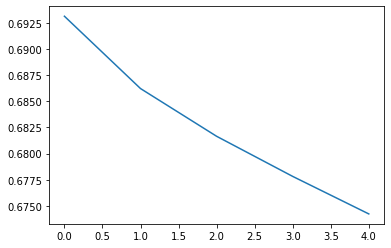

In [76]:
plt.plot(lrnLoss)

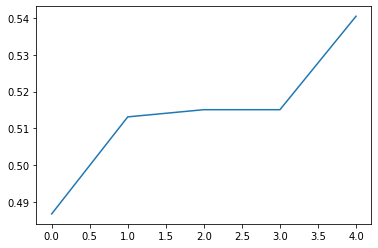

In [77]:
plt.plot(lrnAcc)

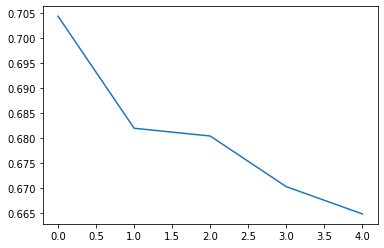

In [78]:
plt.plot(valLoss)

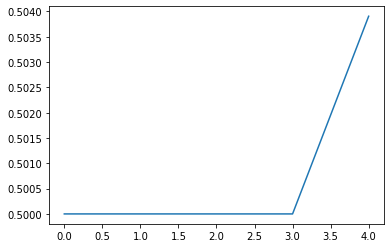

In [79]:
plt.plot(valAcc)

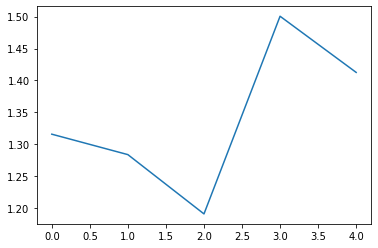

In [80]:
plt.plot(elapTime)

In [87]:
print(tabulate([["Dataset", "Loss", "Accuracy"], ["Training", lrnLoss[-1], lrnAcc[-1]], ["Validation", valLoss[-1], valAcc[-1]]]))

----------  ------------------  ------------------
Dataset     Loss                Accuracy
Training    0.6742244064479908  0.5404089581304771
Validation  0.6648950789669883  0.50390625
----------  ------------------  ------------------


In [100]:
print("  Dataset   |   Loss   | Accuracy")

print("  Training  | %.4f | %.4f" % (lrnLoss[-1], lrnAcc[-1]))
print(" Validation| %.4f | %.4f" % (valLoss[-1], valAcc[-1]))

  Dataset   |   Loss   | Accuracy
  Training  | 0.6742 | 0.5404
 Validation| 0.6649 | 0.5039
